# OpenRank x OSO | Gitcoin Project Rank

_This notebook utilizes the openrank-sdk and various datasets on Open Source Observer to generate a simple demo of a "Gitcoin project rank" algorithm._

* Learn more about how to build notebooks on top of OSO data here: https://docs.opensource.observer/docs/integrate/

* Learn more about the the openrank-sdk here: https://docs.openrank.com/openrank-sdk/installation-and-use

* Learn more about Gitcoin's RegenData set here: https://www.regendata.xyz/

Warning: this implementation is not optimized and may take a while to execute!

In [1]:
#!pip install openrank-sdk

In [2]:
from google.cloud import bigquery
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from openrank_sdk import EigenTrust
import os
import pandas as pd
import seaborn as sns

In [3]:
# make sure you have your GCP credentials in order to access the database
# ... and remember never to commit these into GitHub!
# more info: https://docs.opensource.observer/docs/integrate/python-notebooks#obtain-a-gcp-service-account-key

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../../../gcp_credentials.json"
client = bigquery.Client()

## Query the Gitcoin datasets from OSO

In this example, we look for Gitcoin donors to any of OSS projects in Open Source Observer that also have a Farcaster ID. 

In [4]:
query = """
    with project_mapping as (
      select distinct
        l.project_id as gitcoin_id,
        o.project_name as oso_name,
        o.display_name as display_name
      from `opensource-observer`.`gitcoin`.`project_groups_summary` p
      left join `opensource-observer`.`gitcoin`.`project_lookup` l
        on p.group_id = l.group_id
      join `opensource-observer`.`oso`.`int_artifacts_in_ossd_by_project` a
        on p.latest_project_github = a.artifact_namespace
      join `opensource-observer`.`oso`.`projects_v1` o
        on a.project_id = o.project_id
    )
    
    select
      donations.timestamp,
      farcaster.username as farcaster_username,
      project_mapping.oso_name,
      project_mapping.display_name,
      donations.amount_in_usd  
    from `opensource-observer`.`gitcoin`.`all_donations` as donations
    join `opensource-observer`.`oso`.`stg_farcaster__addresses` f
      on lower(donations.donor_address) = lower(f.address)
    join `opensource-observer`.`oso`.`stg_farcaster__profiles` farcaster
      on f.fid = farcaster.farcaster_id
    join project_mapping
      on donations.project_id = project_mapping.gitcoin_id
"""
result = client.query(query)

In [5]:
df = result.to_dataframe()
df.dropna(inplace=True)
df.nunique()

timestamp             156572
farcaster_username     35014
oso_name                 846
display_name             846
amount_in_usd          49024
dtype: int64

In [6]:
df['amount_in_usd'].sum()

2013005.8071878392

In [7]:
donor_totals = df.groupby('farcaster_username')['amount_in_usd'].sum()
df = df[df['amount_in_usd'] >= 1]
filtered_donors = list(donor_totals[donor_totals>69].index)
df = df[df['farcaster_username'].isin(filtered_donors)]
df.nunique()

timestamp             79793
farcaster_username     4966
oso_name                835
display_name            835
amount_in_usd         20252
dtype: int64

In [8]:
df['amount_in_usd'].sum()

1533892.653263477

## Construct a graph from the event data

Create a graph where nodes are projects and edges represent shared donors. The edge weighting formula is the Euclidean distance between that donor's donation to each project. This should definitely be optimized further!

In [9]:
localtrust = []
trusted_donors = {}
for donor in df['farcaster_username'].unique():

    dff = df[df['farcaster_username'] == donor]
    first_donation = dff['timestamp'].apply(lambda x: x.year).min()
    total_donations = dff['amount_in_usd'].sum()
    if first_donation < 2021:
        trusted_donors.update({donor: total_donations})

    donations = dff.groupby('oso_name')['amount_in_usd'].sum()
    edges = list(combinations(donations.index, r=2))
    for (i,j) in edges:
        v = np.sqrt(donations[i]**2 + donations[j]**2)
        localtrust.append({'i': i, 'j': j, 'v': v})
        localtrust.append({'i': j, 'j': i, 'v': v})

## Run EigenTrust over the graph

This example simply runs the algorithm on the P2P graph, without using a pretrust parameter.

In [10]:
a = EigenTrust()
project_rank = a.run_eigentrust(localtrust)
project_rank[:10]

INFO:root:eigentrust compute took 129.55896024999674 secs 


[{'i': 'commons-stack', 'v': 0.0013584024498821696},
 {'i': 'zlibweb3', 'v': 0.0011199363766464022},
 {'i': 'giveth', 'v': 0.001018433809645243},
 {'i': 'umbra-scopelift', 'v': 0.0010157406303195338},
 {'i': 'pairwise-general-magic', 'v': 0.0009620498766802891},
 {'i': 'fundpg', 'v': 0.0009595680083567663},
 {'i': 'zigzagexchange', 'v': 0.0009135930694768488},
 {'i': 'commonsbuild', 'v': 0.0009038393000744893},
 {'i': 'geo-web', 'v': 0.0008997041035657253},
 {'i': 'brightid', 'v': 0.0008966998057427919}]

[Text(0.5, 0, 'OpenRank `v` value'), Text(0, 0.5, 'Project')]

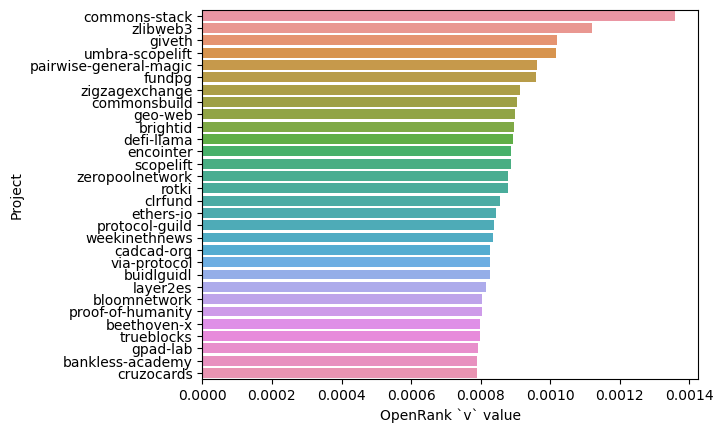

In [11]:
ax = sns.barplot(
    data=pd.DataFrame(project_rank[:30]),
    y='i',
    x='v',
    orient='h'
)
ax.set(xlabel='OpenRank `v` value', ylabel='Project')